In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from importlib.machinery import SourceFileLoader

In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
fun = SourceFileLoader( 'funciones', r'..\..\..\code\modules\funciones.py' ).load_module()
vn  = SourceFileLoader( 'variables_nombres', r'..\..\..\code\modules\variables_nombres.py' ).load_module()

In [3]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

## 1. Matriz de correlación

In [4]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )

In [5]:
most_important_vars = [ '_tejgtotfun_f5r08pgrcopc', '_tejgfun_f5r08ct05pgrcopc', '_tejgtotfun_f5pgrco', 
                        '_tejgfun_f5ct05pgrco', 'dfgpimpiafun_f5ct06pgrco', 'dfgpimpiafun_f5r18ct06pgrco',
                        '_tejgge_r09ct05biser', '_tejgtotfun_f2opseg', '_devppimtotfun_f2transpc',
                        '_devppimfun_f1ct05opseg', '_tejgtotfun_f5amb', 'compu_muni_5', 'devppimtotfun_f5r07trans',
                        '_tejgft_rdet', 'devppimtotfun_f5r07transpc', '_pimgfun_f5r18ct06opseg', '_tejgge_r08ct05biserpc',
                        '_tejgfun_f2ct05opseg', 'dfgpimpiage_r08ct05dotrapc', '_tejgfun_f5ct06ambpc' ]

canon_vars          = [ 'Canon: Total devengado', 'Canon: Total devengado rezagado', 'Canon: Total devengado per cápita', 
                        'Canon: Total ejecutado', 'Canon: Total ejecutado rezagado', 'Canon: Total ejecutado per cápita',
                        'Canon: PIM', 'Canon: PIM rezagado', 'Canon: PIM per cápita' ]

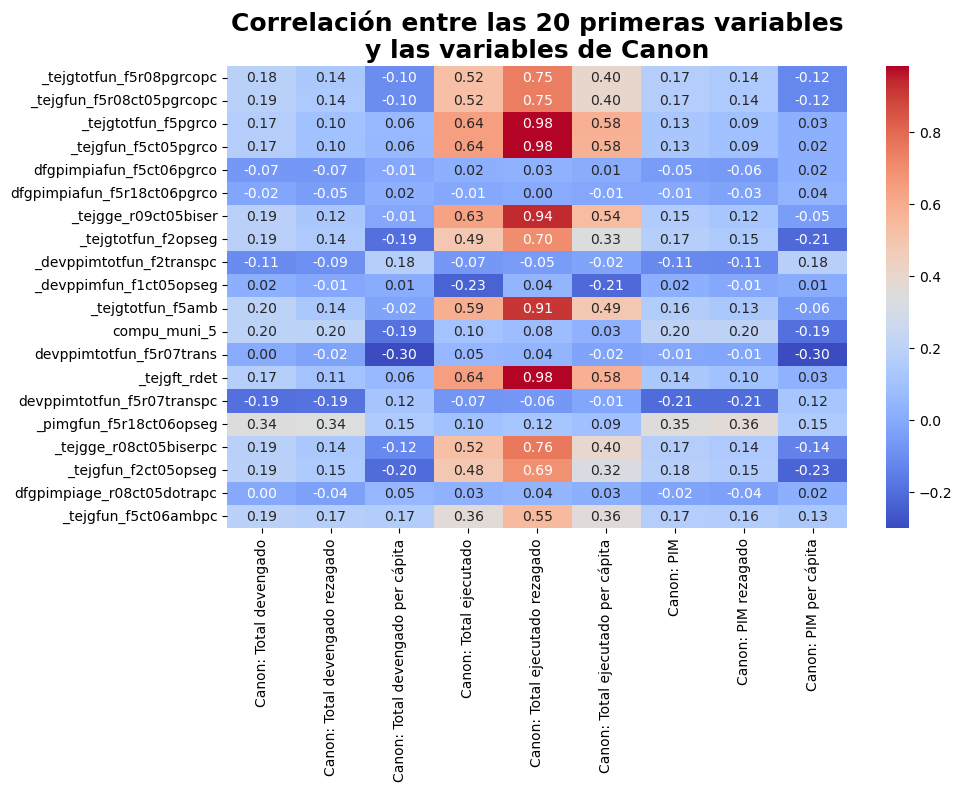

In [6]:
df_subset = data[ most_important_vars + canon_vars ]

correlation_matrix = df_subset.corr()

correlation_matrix_subset = correlation_matrix.loc[ most_important_vars, canon_vars ]

plt.figure( figsize = ( 10, 6 ) )
sns.heatmap( correlation_matrix_subset, annot = True, cmap = 'coolwarm', fmt = ".2f" )
plt.title( 'Correlación entre las 20 primeras variables\ny las variables de Canon', fontsize = 18, fontweight = 'bold' )

plt.savefig( f'../../../output/ejecucion_5/plots/b0_ci_correlation_matrix.jpg',
              format = 'jpg', dpi = 300, bbox_inches = 'tight', pad_inches = 0.1 )
plt.show()

## 2. SHAP Plots

In [7]:
import shap
import joblib
import pickle
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [10]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [14]:
dep_var    = [ 'corrup_intensa' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio', 
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_amplia',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ], 
                                                     data[ 'corrup_intensa' ], 
                                                     test_size    = 0.3,
                                                     random_state = 2023 )

In [15]:
path         = r'..\..\..\output\ejecucion_5\models\base0\model_ci_Random Forest Classifier_3.joblib'
loaded_model = joblib.load( path )

Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [16]:
x_train_s, x_train_st, x_train_nro, y_train_s, y_train_st, y_train_nro = fun.resampling( x_train, y_train )

In [17]:
explainer   = shap.Explainer( loaded_model )
shap_values = explainer( x_train_nro )
np.shape( shap_values.values )

(1366, 14520, 2)

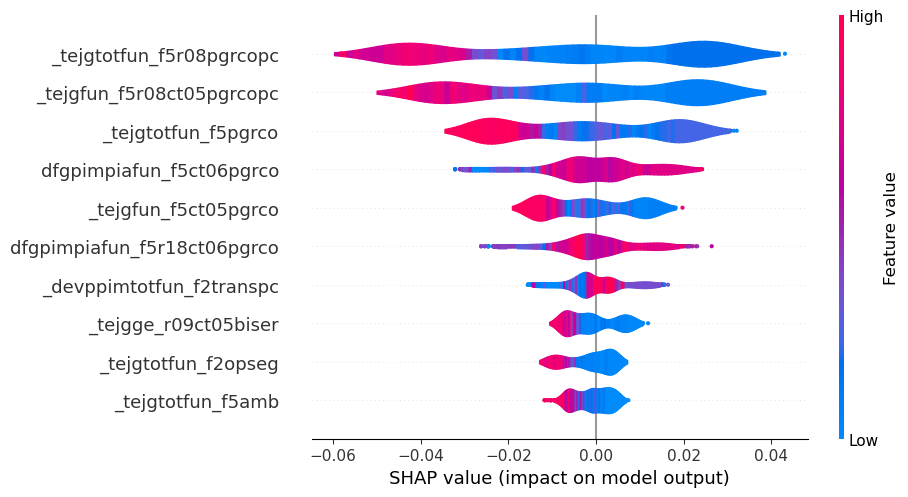

In [19]:
shap.plots.violin( shap_values[ : , : , 1 ], max_display = 10, show = False )
plt.savefig( r'..\..\..\output\ejecucion_5\plots\shap_plot_violin.jpg', dpi = 300, bbox_inches = 'tight', format = 'jpg' )